Support Vector Machine

In [1]:
import numpy as np
from collections import Counter # used to count number of occurrences of each class in training set.


#First Define a class where we can store all functions for the Binary SupportVectorMachine.
class SupportVectorMachine:
    #Specify all variables required to initialise the class, some of which have default values
    
    #regularization_parameter, controls how hard or soft the margin calulation is. The higher the value the more hard
    #  the margin calculation is which doesn't tolerate outliers and will only work with linearly seperable data.
    #  small values makes the margin wider allowing for more noisy data.
    
    #number_iterations, speficies how many times the algorithm is run to maximise the margin, the higher means higher accuracy,
    #  but longer computation time.
    
    
    #Kernel, takes values "linear", "polynomial" and "RBF" where RBF is the default
    # This controls the activation function in the margin calculation, where the formulae can be viewed below.
    # specifies what the plane will resemble , a line for linear, a polynomal, etc.
    
    
    #c and d which specify parameters in polynomial kernel, d is the degree of the polynomial and c is the contant to be added.
    
    #gamma which relates to RBF kernel
    
    def __init__(self,regularization_parameter ,number_iterations,Kernel = None, c= 1,d=2,gamma = 1):
        #Using the self keyword so the variables can be used in different methods in the class
        self.num_iter = number_iterations
        self.C = regularization_parameter
        self.c = c
        self.d = d
        self.gamma = gamma
        
        if Kernel == "linear":
            self.K = self.linear_kernel
        elif Kernel == "polynomial":
            self.K = self.polynomial_kernel
        else:
            self.K = self.RBF_Kernel
            
    #The different Kernels avaiable 
    
    def linear_kernel(self,x,y):
        return sum([x[i]*y[i] for i in range(self.number_of_features)])

    def polynomial_kernel(self,x,y):
        c = self.c
        d = self.d
        return sum([(x[i]*y[i]+c)**d for i in range(self.number_of_features)])

    def RBF_Kernel(self,x,y):
        gamma = self.gamma
        return np.exp(-gamma*sum([(x[i]-y[i])**2 for i in range(self.number_of_features)]))
    
    #A self contained normalisation function to scale the data to either [0,1] range or zero mean 1 variance.
    
    def normalise(self,data,method = "z-normalisation"):
        normalised_data =[point for point in data]
    
        number_of_points = len(data)
        number_of_features = len(data[0])
    
        if method == "zero-to-one":
            for i in range(number_of_features):
                min_feature_value = np.min([data[j][i] for j in range(number_of_points)])
                max_feature_value = np.max([data[j][i] for j in range(number_of_points)]) 
                for j in range(number_of_points):
                    normalised_data[j][i] = (data[j][i] - min_feature_value)/(max_feature_value-min_feature_value)
        else:
            for i in range(number_of_features):
                mean_of_feature = np.mean([data[j][i] for j in range(number_of_points)])
                stdev_of_feature = np.std([data[j][i] for j in range(number_of_points)])
                for j in range(number_of_points):
                    normalised_data[j][i] = (data[j][i] - mean_of_feature)/stdev_of_feature

            
        return normalised_data
    
    def train(self,data,target_var):
        #data is a nested list corresponding to the features of each point
        #target_var must have only two classes and be represented as 1 and -1 respectively
        
        #store these values locally 
        number_of_points = len(data)
        number_of_features = len(data[0])
        #..and globally (within the class)
        self.number_of_points = number_of_points
        self.number_of_features = number_of_features
        
        #We wish to maximise the margin, so we initialise a margin of 0 which will be overwritten through iteration.
        max_margin = -99999
        
        #Here the user specified variable number_iterations is utilised to train the model over however many iterations.
        for n in range(self.num_iter):
            #alpha known as a "slack" variable is a random float value between 0 and the user specified value Regularization Parameter
            #This generally specifies how the SVM will handle errors
            alpha = [rand.uniform(0,self.C) for i in range(number_of_points)]
            margin = 0   #initilse the current margin
 
            #Calculating the max margin iteratively
            for i in range(number_of_points):
                for j in range(number_of_points):
                    margin += alpha[i] - (1/2)*alpha[i]*alpha[j]*target_var[i]*target_var[j]*self.K(data[i],data[j])
            if margin> max_margin:
            #if the new margin has exceeded the previous max, we store it and the alpha vectore
                max_margin = margin
                alpha_star = alpha
            
        #Now solve for w vector 
        w = np.sum([[alpha_star[i]*target_var[i]*x for x in data[i]] for i in range(len(data))], axis = 0)
            
        #x_star which is the list of points which qualify as support vectors to the hyperplane
        x_star = [data.index(x) for x in data for i in range(number_of_features) if sum([x[i]*w[i]]) <= max_margin]
        S = len(x_star)
        #Now calculate the intercept b
        b = sum([target_var[x_star[i]] -sum([w[j]*data[x_star[i]][j] for j in range(number_of_features) ]) for i in range(S)])/S   
        
        self.b = b
        self.w = w


    def predict(self,point):
            
        hypothesis = sum([point[i]*self.w[i] for i in range(self.number_of_features)]) + self.b
        if hypothesis >= 0:
            return 1
        else:
            return -1
            
    #method to return the plane of the SVM
    def get_plane(self):
        plane = [self.w,self.b]
        return plane


class MCSupportVectorMachine:
    #Multi-class SupportVectorMachine
    def __init__(self,regularization_parameter ,number_iterations,Kernel = None, c= 1,d=2,gamma = 1,comparison_method = None):
        #Same input parameters as binary class SVM with one addition
        #Comparison_method takes values "one_v_one" and "one_v_all" with one_v_all being the default
        #Import binary SVM with given parameters
        self.mySVM = SupportVectorMachine(regularization_parameter ,number_iterations, Kernel, c,d,gamma)
        self.compare = comparison_method

    def normalise(self,data,method = "zero-to-one"):
        return self.mySVM.normalise(data,method)
        
        
    def train(self,data,target_var):
        #data is a nested list corresponding to the features of each point
        #target_var can have any amount of classes and be represented by any type e.g. String, Double etc.
        
        classes = list(set(target_var))  #get list of unique classes in training set
        num_classes = len(classes)  #number of classes there are
        num_points = len(data) #number of data points
        #Here we take each class any map it to an integer starting from 1
        classes_translated = [i for i in range(1,num_classes+1)] 
        #With a corresponding integer for every class, we now map all of the target variables to their respective integer values
        target_var_translated = [classes_translated[j] for j in range(num_classes) for i in range(num_points) if target_var[i] == classes[j]]
        
        mySVM = self.mySVM #import initialized SVM from _init_
        
        planes = []    #To store each plane for binary classification to use for multi-classification
        tries = [i for i in classes_translated]  #Creat a copy of the list of integer classes called tries
        if self.compare == "one_v_one":
            while len(tries)>1:
            # this will iterate through s.t. every class with be compared with every other class
                for itr1 in range(len(tries)):
                    current_class = tries.pop(0) #Remove and store the class to be compared against every other
                    for itr2 in range(len(tries)): #loop through the remaining classes in tries
                        class_to_compare = [current_class,tries[itr2]] #the two classes being compared
                        #Remove all data point which are not of the current two classes
                        sub_data = [data[i] for i in range(num_points) if target_var_translated[i] in class_to_compare] 
                        sub_target = [target_var_translated[i] for i in range(num_points) if target_var_translated[i] in class_to_compare ]
                        new_target = [1 if sub_target[i] == current_class else -1 for i in range(len(sub_target))]
                        #train a binary SVM on these two classes
                        mySVM.train(sub_data, new_target)
                        
                        class_to_compare[1] = [class_to_compare[1]]  #Storing this as a list to be consistent with the
            #one_vs_rest approach which has the second elt of class to compare as a list. noted by **
                        class_to_compare.append(mySVM.get_plane())
            
                        planes.append(class_to_compare) #Store the two classes compared and the plane dividing each
                        
          
        else:   #One_vs_rest approach
            for itr in range(len(tries)):
                current_class = tries[itr]
                other_classes = [otherClass for otherClass in classes_translated if otherClass != current_class]
            
                class_to_compare = [current_class,other_classes] #**
            #now map the current_class label to +1 and every other to -1
                new_target = [1 if target_var_translated[i] == current_class else -1 for i in range(len(target_var_translated))]
                mySVM.train(data, new_target)
                class_to_compare.append(mySVM.get_plane())
                planes.append(class_to_compare)
        
        #Store these values globally for the predict method to use them
        self.planes = planes
        self.classes = classes
        self.classes_translated = classes_translated
        self.number_of_features = len(data[0])
        self.target_var = target_var
            
    def predict(self,point):
        classes = self.classes
        classes_translated = self.classes_translated
        votes = [0] * len(classes) # Votes to be awarded for each class
        
        for plane in self.planes:
            
            class_to_compare = [plane[0],plane[1]] #taking each binary classifier one by one
            w = plane[2][0]
            b = plane[2][1]
            hypothesis = sum([point[i]*w[i] for i in range(self.number_of_features)]) + b
            if hypothesis >= 0:
                #award one vote to the correct class
                votes[classes_translated.index(class_to_compare[0])] += 1
                for all_classes in class_to_compare[1]:
                    votes[classes_translated.index(all_classes)] -= 1 #remove a vote from (all) the incorrect class(s)
            else:
                votes[classes_translated.index(class_to_compare[0])] -= 1
                for all_classes in class_to_compare[1]:
                    votes[classes_translated.index(all_classes)] += 1

        max_votes = max(votes) # find which class has the max vote
        classes_with_max_vote = [votes.index(mv) for mv in votes if mv == max_votes]
        
        count = Counter(self.target_var)
        
        #If there is a draw, return the most common class out of the equal voted classes
        if len(classes_with_max_vote) > 1:
            oldcount=0
            for clas in classes_with_max_vote:
                newcount = count[classes[clas]]
                if newcount > oldcount:
                    oldcount = newcount
                    winner = clas
        else:
            winner = votes.index(max_votes)  # find the index of this max value
        
        
        return classes[winner] #return the class with most votes
            

In [2]:
import random as rand
import pandas as pd
rand.seed(100) #setting the seed so our results are consistent for comparison purposes

#In this chunk I test the performance of the Binary SVM

beer = pd.read_csv('beer.txt', sep="\t", header=None) #import the data
#label the data
beer.columns = ["calorific_value", "nitrogen", "turbidity", "style", "alcohol", "sugars", "bitterness", "beer_id", "colour", "degree_of_fermentation"]

beer = beer[beer["style"] != "lager"] # removing lager class from target variable
beer["style"] == "lager"
beer = beer.reset_index()
# now set ale = 1 and stout = -1
target = np.ones(len(beer)) 
for i in range(len(target)):
    if beer['style'][i] == 'stout':
        target[i] = -1

beer = beer.drop(columns=['index','style','beer_id']) #removing unnecessary columns from our feature list

mySVM = SupportVectorMachine(2,1000,Kernel = 'linear') #initiate the Binary SVM

beerdata = np.array(mySVM.normalise(beer.values,"zero-to-one"))

#divide the data into 1/3 test and 2/3 train
number_of_test_points = int(len(target)/3)
rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))

test_data = beerdata[rows_for_test].tolist()
test_target = target[rows_for_test].tolist()
train_data = np.delete(beerdata,rows_for_test,axis =0).tolist()
train_target = np.delete(target,rows_for_test,axis =0).tolist()



mySVM.train(train_data,train_target)

pred = [mySVM.predict(point) for point in test_data]
np.mean([pred[i] == test_target[i] for i in range(len(pred))]) #checking the score of the predicticted output

0.9393939393939394

In [2]:
rand.seed(100) 

#In this chunk I test the performance of the Multi-class SVM

beer = pd.read_csv('beer.txt', sep="\t", header=None)
beer.columns = ["calorific_value", "nitrogen", "turbidity", "style", "alcohol", "sugars", "bitterness", "beer_id", "colour", "degree_of_fermentation"]

#seperate data in feature list and target 
target =beer['style'].values
beer = beer.drop(columns=['style','beer_id'])


mySVM = MCSupportVectorMachine(2,1000, comparison_method = "one_v_one", Kernel = "linear")
beerdata = np.array(mySVM.normalise(beer.values))

number_of_test_points = int(len(target)/3)
rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))

test_data = beerdata[rows_for_test].tolist()
test_target = target[rows_for_test].tolist()
train_data = np.delete(beerdata,rows_for_test,axis =0).tolist()
train_target = np.delete(target,rows_for_test,axis =0).tolist()

mySVM.train(train_data,train_target)
pred = [mySVM.predict(point) for point in test_data]
print("z_normalised score =  " + str(np.mean([pred[i] == test_target[i] for i in range(len(pred))])))

beerdata = np.array(mySVM.normalise(beer.values,"zero-to-one"))

number_of_test_points = int(len(target)/3)
rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))

test_data = beerdata[rows_for_test].tolist()
test_target = target[rows_for_test].tolist()
train_data = np.delete(beerdata,rows_for_test,axis =0).tolist()
train_target = np.delete(target,rows_for_test,axis =0).tolist()

mySVM.train(train_data,train_target)
pred = [mySVM.predict(point) for point in test_data]
print("zero-to-one score = "  + str(np.mean([pred[i] == test_target[i] for i in range(len(pred))])))

beerdata = beer.values

number_of_test_points = int(len(target)/3)
rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))

test_data = beerdata[rows_for_test].tolist()
test_target = target[rows_for_test].tolist()
train_data = np.delete(beerdata,rows_for_test,axis =0).tolist()
train_target = np.delete(target,rows_for_test,axis =0).tolist()

SVM = MCSupportVectorMachine(3,1000, comparison_method = "one_v_one", gamma = 3 )
SVM.train(train_data,train_target)
pred = [mySVM.predict(point) for point in test_data]
print("Not Normalised score = "  + str(np.mean([pred[i] == test_target[i] for i in range(len(pred))])))


#output predicted and actual values to a file

output = pd.DataFrame({'Predicted': pred,
                   'Actual': test_target})
output.to_csv(index=False)


z_normalised score =  0.3137254901960784
zero-to-one score = 0.49019607843137253
Not Normalised score = 0.29411764705882354


In [ ]:
rand.seed(100)

#iterating through different hyper parameters to fine tune the SVM

beer = pd.read_csv('beer.txt', sep="\t", header=None)
beer.columns = ["calorific_value", "nitrogen", "turbidity", "style", "alcohol", "sugars", "bitterness", "beer_id", "colour", "degree_of_fermentation"]

target =beer['style'].values
beer = beer.drop(columns=['style','beer_id'])

beerdata = np.array(mySVM.normalise(beer.values))

number_of_test_points = int(len(target)/3)
rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))

test_data = mySVM.normalise(beerdata[rows_for_test].tolist())
test_target = target[rows_for_test].tolist()
train_data = mySVM.normalise(np.delete(beerdata,rows_for_test,axis =0).tolist())
train_target = np.delete(target,rows_for_test,axis =0).tolist()

regularization_parameter_ = [i for i in range(1,5)]
Kernel_ = ["linear","polynomial","RBF"]
c_ = [i for i in range(1,3)]
gamma_ = [i for i in range(1,6)]
d=2

for c__ in c_:
    mySVM = MCSupportVectorMachine(regularization_parameter =1 ,number_iterations = 500,Kernel = "polynomial", c= c__,d=d,gamma = 1,comparison_method = None)
    mySVM.train(train_data,train_target)
    pred = [mySVM.predict(point) for point in test_data]
    m = np.mean([pred[i] == test_target[i] for i in range(len(pred))])
    print("polynomial score with c = " + str(c__) + " and d = " + str(d) + " = " + str(m))

for C in regularization_parameter_:
    
    mySVM = MCSupportVectorMachine(regularization_parameter =C ,number_iterations = 500,Kernel = "linear",gamma = 1,comparison_method = None)
    mySVM.train(train_data,train_target)
    pred = [mySVM.predict(point) for point in test_data]
    m = np.mean([pred[i] == test_target[i] for i in range(len(pred))])
    print("linear score with Regularization parameter = " + str(C) + " = " + str(m))
        
        
for C in regularization_parameter_:        
    for gam in gamma_:
            mySVM = MCSupportVectorMachine(regularization_parameter =C ,number_iterations = 500,Kernel = None,gamma = gam,comparison_method = None)
            mySVM.train(train_data,train_target)
            pred = [mySVM.predict(point) for point in test_data]
            m = np.mean([pred[i] == test_target[i] for i in range(len(pred))])
            print("RBF score with gamma = " + str(gam) + "and Regularization parameter = " + str(C) + " = " + str(m))   
    


polynomial score with c = 1 and d = 2 = 0.37254901960784315
polynomial score with c = 2 and d = 2 = 0.37254901960784315
linear score with Regularization parameter = 1 = 0.39215686274509803
linear score with Regularization parameter = 2 = 0.37254901960784315
linear score with Regularization parameter = 3 = 0.37254901960784315
linear score with Regularization parameter = 4 = 0.37254901960784315
RBF score with gamma = 1and Regularization parameter = 1 = 0.39215686274509803
RBF score with gamma = 2and Regularization parameter = 1 = 0.35294117647058826
RBF score with gamma = 3and Regularization parameter = 1 = 0.35294117647058826
RBF score with gamma = 4and Regularization parameter = 1 = 0.35294117647058826
RBF score with gamma = 5and Regularization parameter = 1 = 0.39215686274509803
RBF score with gamma = 1and Regularization parameter = 2 = 0.35294117647058826
RBF score with gamma = 2and Regularization parameter = 2 = 0.39215686274509803
RBF score with gamma = 3and Regularization paramete

In [6]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Importing scikitlearn SVC as a base to compare 
#Using RBF kernel for comparison
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) #This will scale the data then use 
mySVM = MCSupportVectorMachine(3,1000, comparison_method = "one_v_one", gamma = 3 )



my_preprocessed_data = np.array(mySVM.normalise(beerdata))

RBF_results = []
RBF_comparison = []
for cross_validation in range(10):
    rand.seed(7*cross_validation + 1) # a constant random seed each iteration for comparison and tracing purposes
    
    number_of_test_points = int(len(target)/3)
    rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))
    

    test_target = target[rows_for_test].tolist()
    train_target = np.delete(target,rows_for_test,axis =0).tolist()

    clf_test_data = beerdata[rows_for_test].tolist()
    clf_train_data = np.delete(beerdata,rows_for_test,axis =0).tolist()
    
    my_test_data = my_preprocessed_data[rows_for_test].tolist()
    my_train_data = np.delete(my_preprocessed_data,rows_for_test,axis =0).tolist()

    
    clf.fit(clf_train_data,train_target)
    clf_predict = [clf.predict([point]) for point in clf_test_data]
    clf_predict = [clf_predict[i][0] for i in range(len(clf_predict))]
        
    mySVM.train(my_train_data,train_target)
    my_predict = [mySVM.predict(point) for point in my_test_data]
    
    clf_score = np.mean([clf_predict[i] == test_target[i] for i in range(len(pred))] )
    my_score = np.mean([my_predict[i] == test_target[i] for i in range(len(pred))])

    RBF_results.append([my_predict,clf_predict,test_target])
    RBF_comparison.append([my_score,clf_score])
    
print("My 10 fold cross vaildation score = " + str(np.mean([RBF_comparison[i][0] for i in range(len(RBF_comparison))])))
print("Base 10 fold cross vaildation score = " + str(np.mean([RBF_comparison[i][1] for i in range(len(RBF_comparison))])))




My 10 fold cross vaildation score = 0.3411764705882353
Base 10 fold cross vaildation score = 0.972549019607843


In [7]:
clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
mySVM = MCSupportVectorMachine(2,1000, comparison_method = "one_v_one", Kernel = 'linear' )
#Using linear kernel for comparison
my_preprocessed_data = np.array(mySVM.normalise(beerdata))

lin_results = []
lin_comparison = []
for cross_validation in range(10):
    rand.seed(7*cross_validation + 1)
    
    number_of_test_points = int(len(target)/3)
    rows_for_test = sorted(rand.sample(range(len(target)), number_of_test_points))
    

    test_target = target[rows_for_test].tolist()
    train_target = np.delete(target,rows_for_test,axis =0).tolist()

    clf_test_data = beerdata[rows_for_test].tolist()
    clf_train_data = np.delete(beerdata,rows_for_test,axis =0).tolist()
    
    my_test_data = my_preprocessed_data[rows_for_test].tolist()
    my_train_data = np.delete(my_preprocessed_data,rows_for_test,axis =0).tolist()

    
    clf.fit(clf_train_data,train_target)
    clf_predict = [clf.predict([point]) for point in clf_test_data]
    clf_predict = [clf_predict[i][0] for i in range(len(clf_predict))]
    
        
    mySVM.train(my_train_data,train_target)
    my_predict = [mySVM.predict(point) for point in my_test_data]
    
    clf_score = np.mean([clf_predict[i] == test_target[i] for i in range(len(pred))] )
    my_score = np.mean([my_predict[i] == test_target[i] for i in range(len(pred))])

    lin_results.append([my_predict,clf_predict,test_target])
    lin_comparison.append([my_score,clf_score])
    
print("My 10 fold cross vaildation score = " + str(np.mean([lin_comparison[i][0] for i in range(len(lin_comparison))])))
print("Base 10 fold cross vaildation score = " + str(np.mean([lin_comparison[i][1] for i in range(len(lin_comparison))])))



My 10 fold cross vaildation score = 0.3431372549019608
Base 10 fold cross vaildation score = 0.9509803921568627


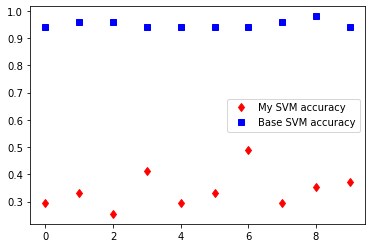

In [10]:
y1 = [lin_comparison[i][0] for i in range(10)]
y2 = [lin_comparison[i][1] for i in range(10)]

my_accuracy, = plt.plot(y1,'rd', label='My SVM accuracy')
base_accuracy, = plt.plot(y2,'bs', label='Base SVM accuracy')
plt.legend(handles=[my_accuracy, base_accuracy])
plt.show()

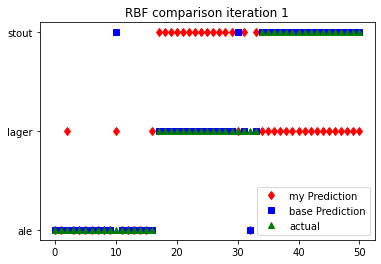

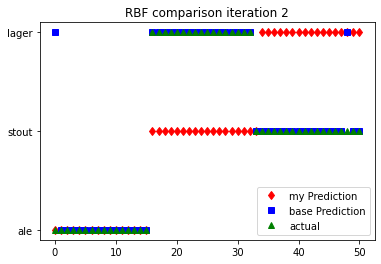

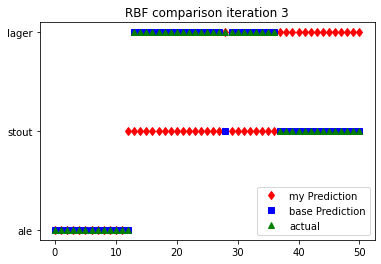

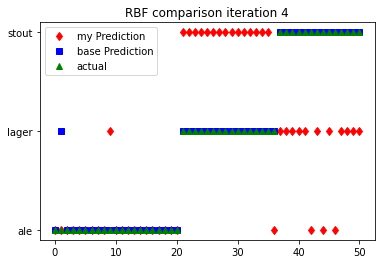

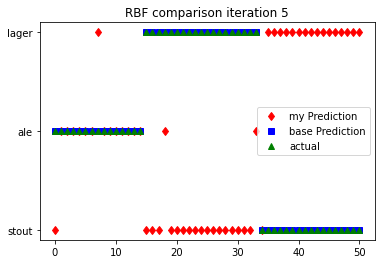

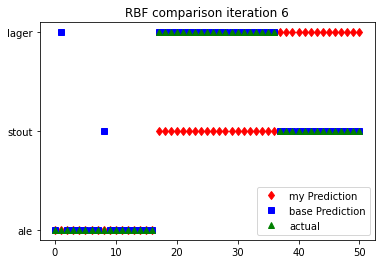

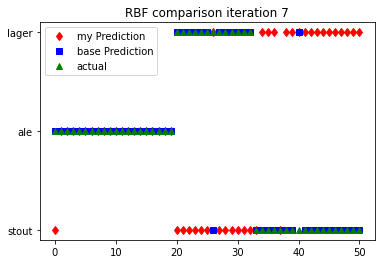

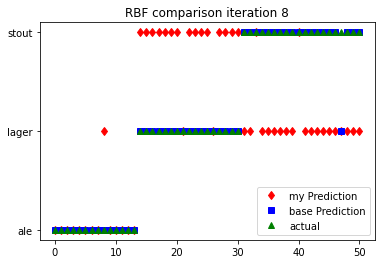

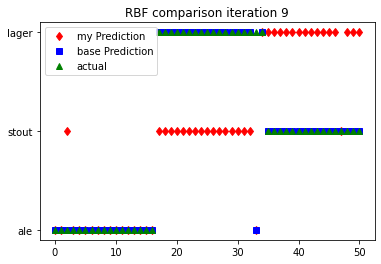

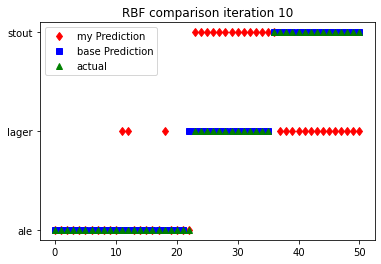

In [13]:
Y1 = [RBF_results[i][0] for i in range(len(RBF_results))]
Y2 = [RBF_results[i][1] for i in range(len(RBF_results))]
Y3 = [RBF_results[i][2] for i in range(len(RBF_results))]

for i in range(10):  
    plt.figure()
    plt.title("RBF comparison iteration " + str(i+1) )
    plt.plot(Y1[i],'rd', label = 'my Prediction')
    plt.plot(Y2[i],'bs',label = 'base Prediction')
    plt.plot(Y3[i],'g^',label = 'actual')
    plt.legend()
    plt.show()

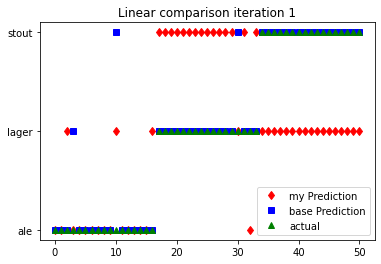

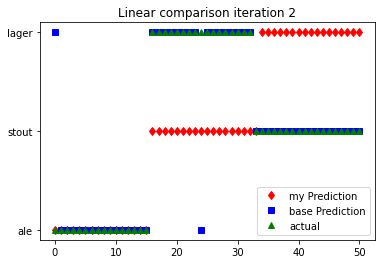

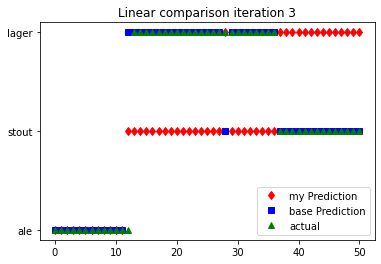

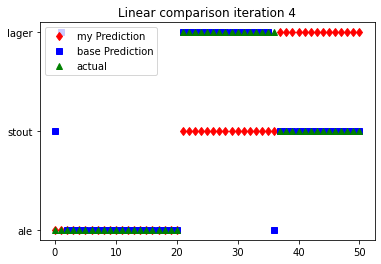

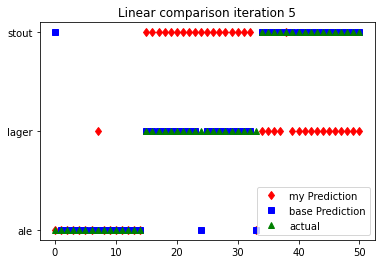

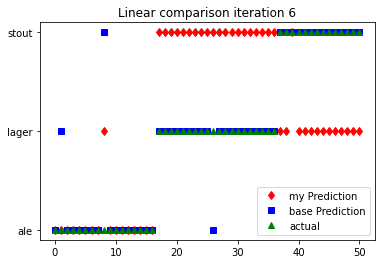

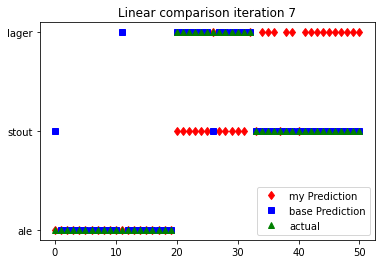

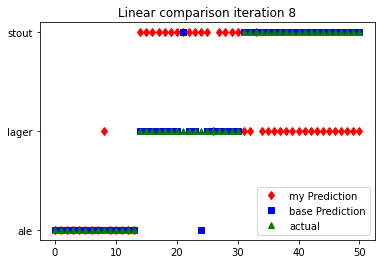

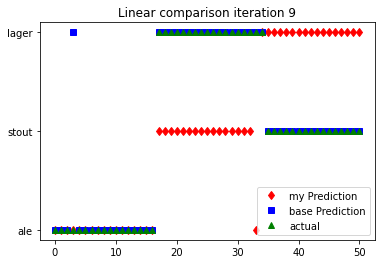

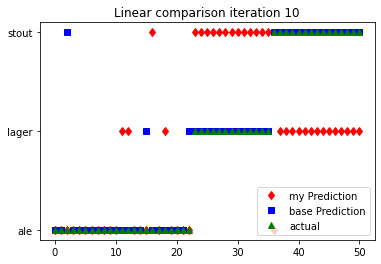

In [15]:
Y1 = [lin_results[i][0] for i in range(len(lin_results))]
Y2 = [lin_results[i][1] for i in range(len(lin_results))]
Y3 = [lin_results[i][2] for i in range(len(lin_results))]

for i in range(10):  
    plt.figure()
    plt.title("Linear comparison iteration "  + str(i+1))
    plt.plot(Y1[i],'rd', label = 'my Prediction')
    plt.plot(Y2[i],'bs',label = 'base Prediction')
    plt.plot(Y3[i],'g^',label = 'actual')
    plt.legend()
    plt.show()